In [1]:
import typing
import io
import os

import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt

from urllib.request import urlretrieve

from PIL import Image
from torchvision import transforms

from models.vit import VisionTransformer, CONFIGS

In [2]:
os.makedirs("attention_data", exist_ok=True)
if not os.path.isfile("attention_data/ilsvrc2012_wordnet_lemmas.txt"):
    urlretrieve("https://storage.googleapis.com/bit_models/ilsvrc2012_wordnet_lemmas.txt", "attention_data/ilsvrc2012_wordnet_lemmas.txt")
if not os.path.isfile("attention_data/ViT-B_16-224.npz"):
    urlretrieve("https://storage.googleapis.com/vit_models/imagenet21k+imagenet2012/ViT-B_16-224.npz", "attention_data/ViT-B_16-224.npz")

imagenet_labels = dict(enumerate(open('attention_data/ilsvrc2012_wordnet_lemmas.txt')))

In [3]:
# Prepare Model
config = CONFIGS["ViT-B_16"]
model = VisionTransformer(config, num_classes=1000, zero_head=False, img_size=224, vis=True)
model.load_from(np.load("attention_data/ViT-B_16-224.npz"))
model.eval()

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])
im = Image.open("data/snow/test/armytank/12464036585_364313304b_c.jpg")
x = transform(im)
x.size()

torch.Size([3, 224, 224])

In [6]:
logits, att_mat = model(x.unsqueeze(0))

att_mat = torch.stack(att_mat).squeeze(1)
print(att_mat.shape, att_mat[:,0 ].shape)

# Average the attention weights across all heads.
# att_mat = torch.mean(att_mat, dim=1)
def get_each_attn_mask(att_mat):
    # To account for residual connections, we add an identity matrix to the
    # attention matrix and re-normalize the weights.
    residual_att = torch.eye(att_mat.size(1))
    aug_att_mat = att_mat + residual_att
    aug_att_mat = aug_att_mat / aug_att_mat.sum(dim=-1).unsqueeze(-1)

    # Recursively multiply the weight matrices
    joint_attentions = torch.zeros(aug_att_mat.size())
    joint_attentions[0] = aug_att_mat[0]

    for n in range(1, aug_att_mat.size(0)):
        joint_attentions[n] = torch.matmul(aug_att_mat[n], joint_attentions[n-1])

    # Attention from the output token to the input space.
    v = joint_attentions[-1]
    grid_size = int(np.sqrt(aug_att_mat.size(-1)))
    print(v.shape, grid_size)
    mask = v[0, 1:].reshape(grid_size, grid_size).detach().numpy()
    # mask = cv2.resize(mask / mask.max(), im.size)[..., np.newaxis]
    # result = (mask * im).astype("uint8")
    return mask

results = [get_each_attn_mask(att_mat[:, i]) for i in range(12)]

tensor([[0.6344, 0.0023, 0.0020,  ..., 0.0018, 0.0020, 0.0027],
        [0.1340, 0.3149, 0.0324,  ..., 0.0037, 0.0040, 0.0041],
        [0.1081, 0.0336, 0.3098,  ..., 0.0040, 0.0043, 0.0027],
        ...,
        [0.1284, 0.0027, 0.0042,  ..., 0.2976, 0.0460, 0.0102],
        [0.1307, 0.0026, 0.0041,  ..., 0.0412, 0.3032, 0.0362],
        [0.1514, 0.0027, 0.0035,  ..., 0.0107, 0.0365, 0.3501]],
       grad_fn=<SelectBackward>)


Prediction Label and Attention Map!

0.22605 : snowplow, snowplough
0.18024 : tank, army_tank, armored_combat_vehicle, armoured_combat_vehicle
0.10759 : amphibian, amphibious_vehicle
0.10579 : half_track
0.10197 : jeep, landrover


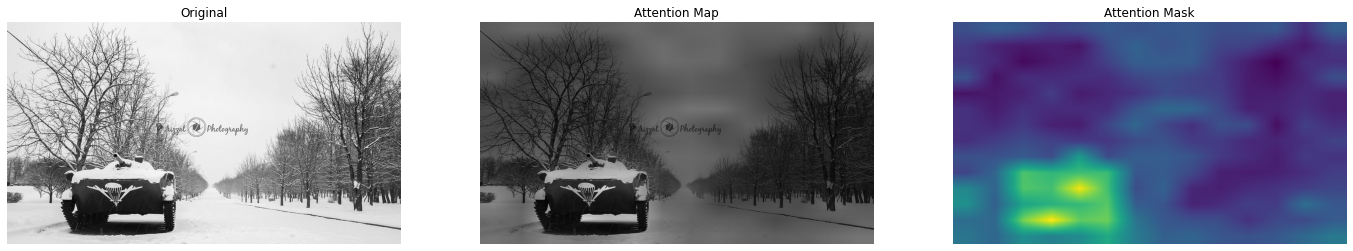

In [22]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(24, 16))

ax1.set_title('Original')
# ax2.set_title('Attention Map')
ax3.set_title('Attention Mask')
ax3.set_title('Attention Mask')
_ = ax1.imshow(im)
_ = ax2.imshow(results[0])
_ = ax2.imshow(results[1])
ax1.set_axis_off()
ax2.set_axis_off()
ax3.set_axis_off()

probs = torch.nn.Softmax(dim=-1)(logits)
top5 = torch.argsort(probs, dim=-1, descending=True)
print("Prediction Label and Attention Map!\n")
for idx in top5[0, :5]:
    print(f'{probs[0, idx.item()]:.5f} : {imagenet_labels[idx.item()]}', end='')

### Reference
* [attention_flow](https://github.com/samiraabnar/attention_flow)
* [vit-keras](https://github.com/faustomorales/vit-keras)

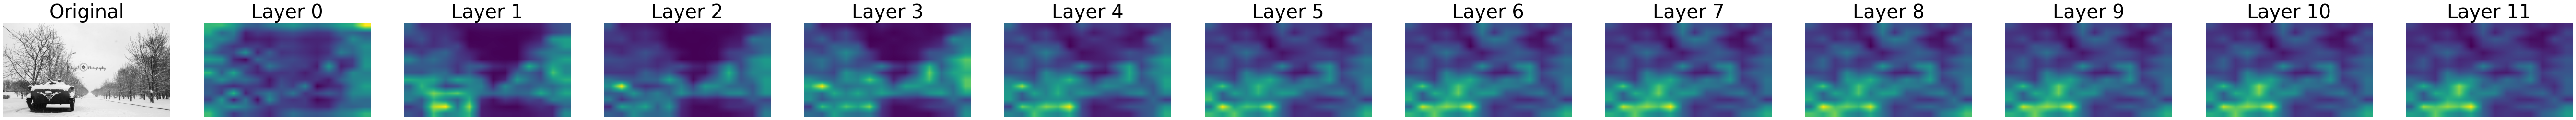

In [15]:
fig, axs = plt.subplots(ncols=len(joint_attentions)+1, figsize=(8*len(joint_attentions), 16))
axs[0].set_title('Original', fontsize=40)
axs[0].imshow(im)
axs[0].set_axis_off()
for i, v in enumerate(joint_attentions):
    # Attention from the output token to the input space.
    mask = v[0, 1:].reshape(grid_size, grid_size).detach().numpy()
    mask = cv2.resize(mask / mask.max(), im.size)[..., np.newaxis]
    result = (mask * im).astype("uint8")
    axs[i+1].set_title(f'Layer {i}', fontsize=40)
    _ = axs[i+1].imshow(mask)
    axs[i+1].set_axis_off()